# Visual Question Answering on Invoices &#x1F60E;

The aim of this notebook is to show how to apply Visual QA on **RVL_CDIP** invoices.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/webinar/webinars/VisualQuestionAnsweringOnInvoices.ipynb)


### Colab Setup

In [0]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing Spark OCR
!pip install --upgrade -q spark-ocr==$OCR_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

### Initialize Spark session

In [ ]:
from sparkocr import start
import pkg_resources
from pyspark import SparkConf
from pyspark.ml import PipelineModel
import os

from sparkocr.transformers import *
from sparkocr.utils import display_images, display_table, display_tables
from sparkocr.enums import *

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = start(license_keys['SPARK_OCR_SECRET'], extra_conf=params)
spark

### Get the Data!
You can download the entire test set of RVL-CDIP(https://adamharley.com/rvl-cdip/) or just pick a few examples, and place them under ./RVL-CDIP/test.

In [0]:
imagePath_ = "./RVL-CDIP/test/*"
df = spark.read.format("binaryFile").load(imagePath_).repartition(60).cache()

This is what running on the entire dataset looks like, almost 40k images!

In [0]:
df.count()

Out[3]: 39947

If you have the entire dataset, you want to run this for efficiency, otherwise you can ignore following cell,

In [0]:
df = df.repartition(256)
df.rdd.getNumPartitions()

Out[4]: 256

In [0]:
from sparkocr.transformers import *
from sparkocr.enums import *
from pyspark.ml import PipelineModel

binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

doc_class = VisualDocumentClassifierV3() \
    .pretrained("dit_base_finetuned_rvlcdip", "en", "clinical/ocr") \
    .setInputCols(["image"]) \
    .setOutputCol("label")

# OCR pipeline
ocrpipeline = PipelineModel(stages=[
    binary_to_image,
    doc_class
])

result = ocrpipeline.transform(df).cache()

In [0]:
result.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- exception: string (nullable = true)



In [0]:
invoices = result.filter(result['label'] == 'invoice')


    Image #0:
    Origin: dbfs:/mnt/s3_dev/ocr/datasets/RVL-CDIP/test/form/2061832180.tif
    Resolution: 72 dpi
    Width: 788 px
    Height: 1000 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


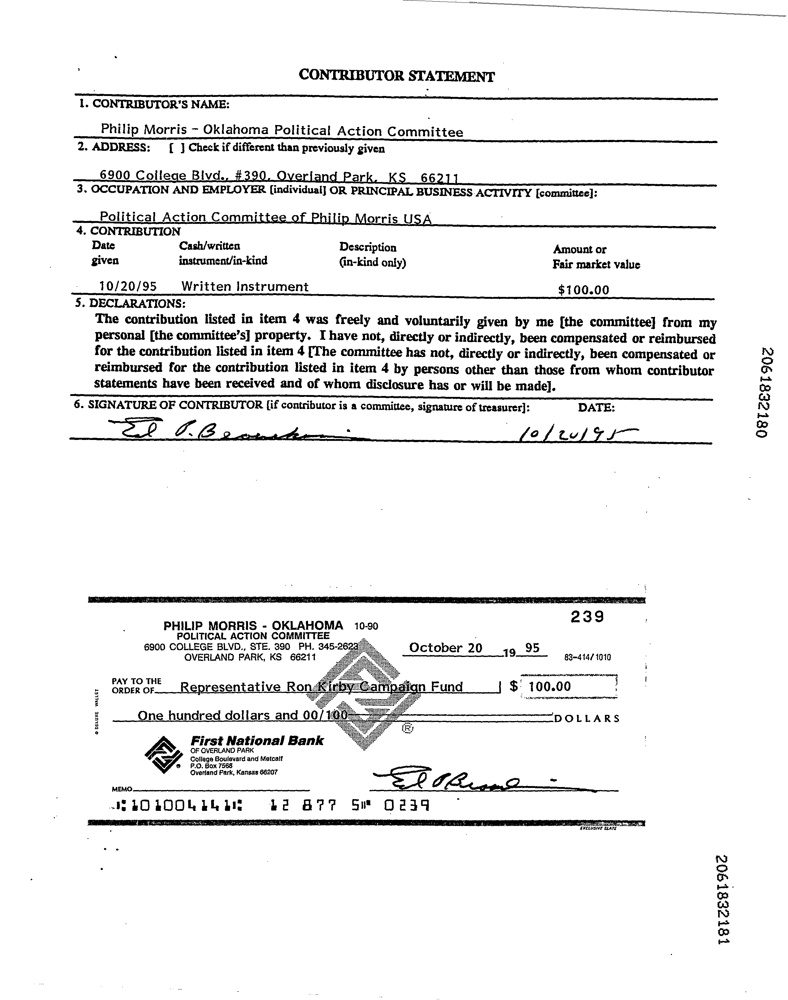


    Image #1:
    Origin: dbfs:/mnt/s3_dev/ocr/datasets/RVL-CDIP/test/invoice/82895075.tif
    Resolution: 72 dpi
    Width: 766 px
    Height: 1000 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


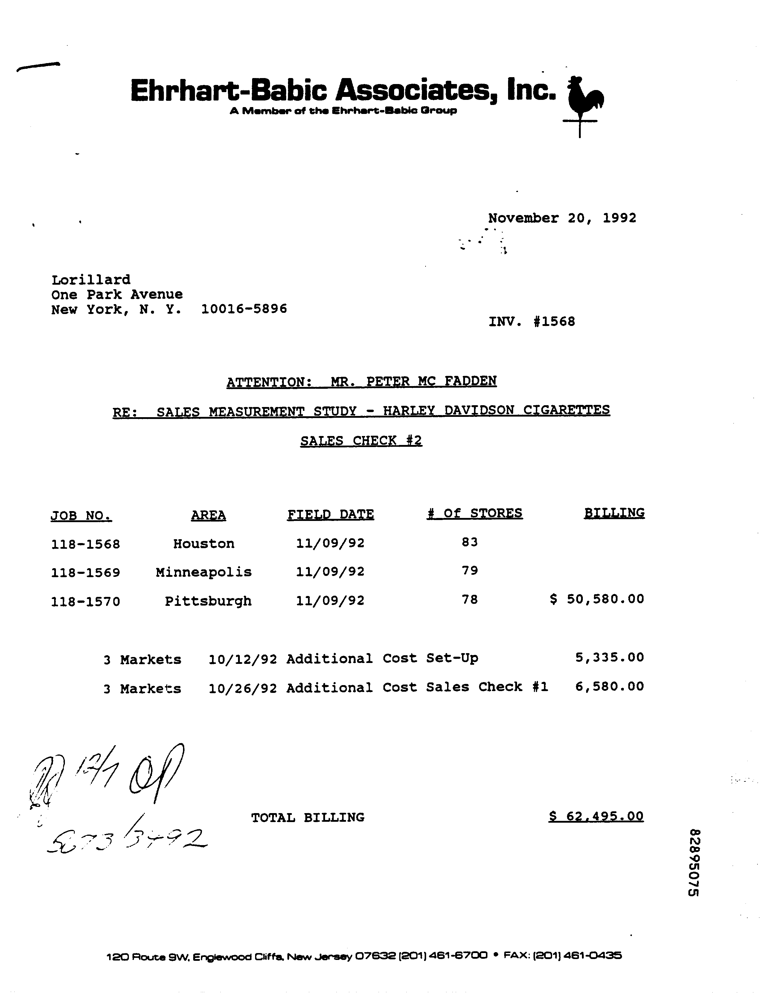


    Image #2:
    Origin: dbfs:/mnt/s3_dev/ocr/datasets/RVL-CDIP/test/invoice/1000789391.tif
    Resolution: 72 dpi
    Width: 777 px
    Height: 1000 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


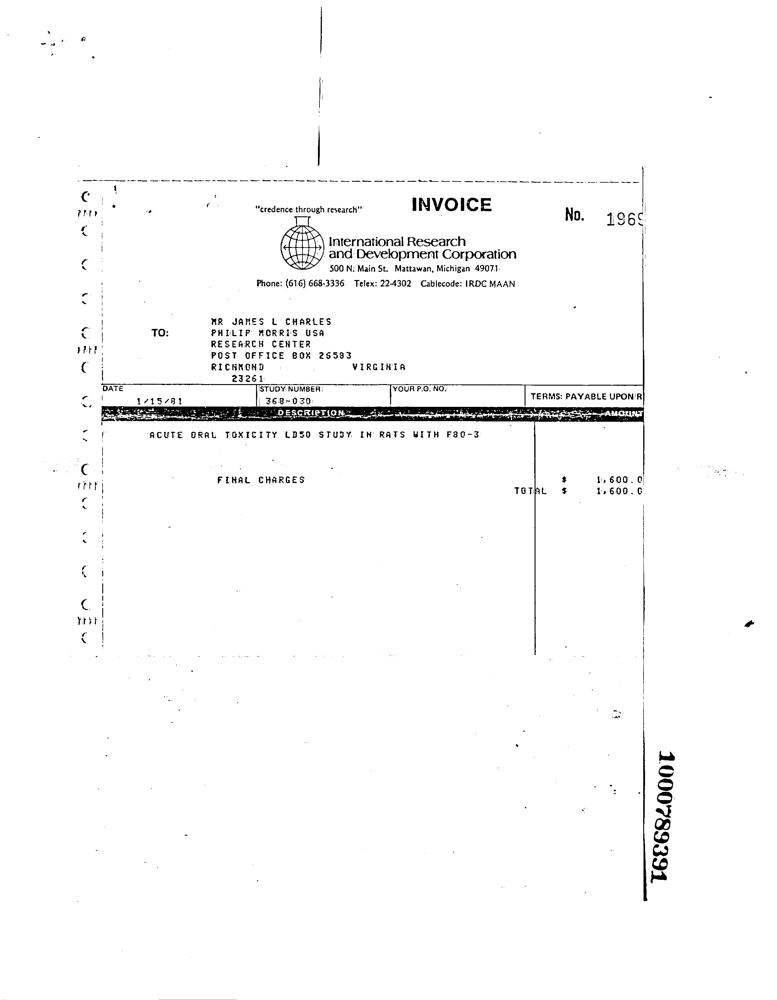


    Image #3:
    Origin: dbfs:/mnt/s3_dev/ocr/datasets/RVL-CDIP/test/invoice/91572983_2984.tif
    Resolution: 72 dpi
    Width: 754 px
    Height: 1000 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


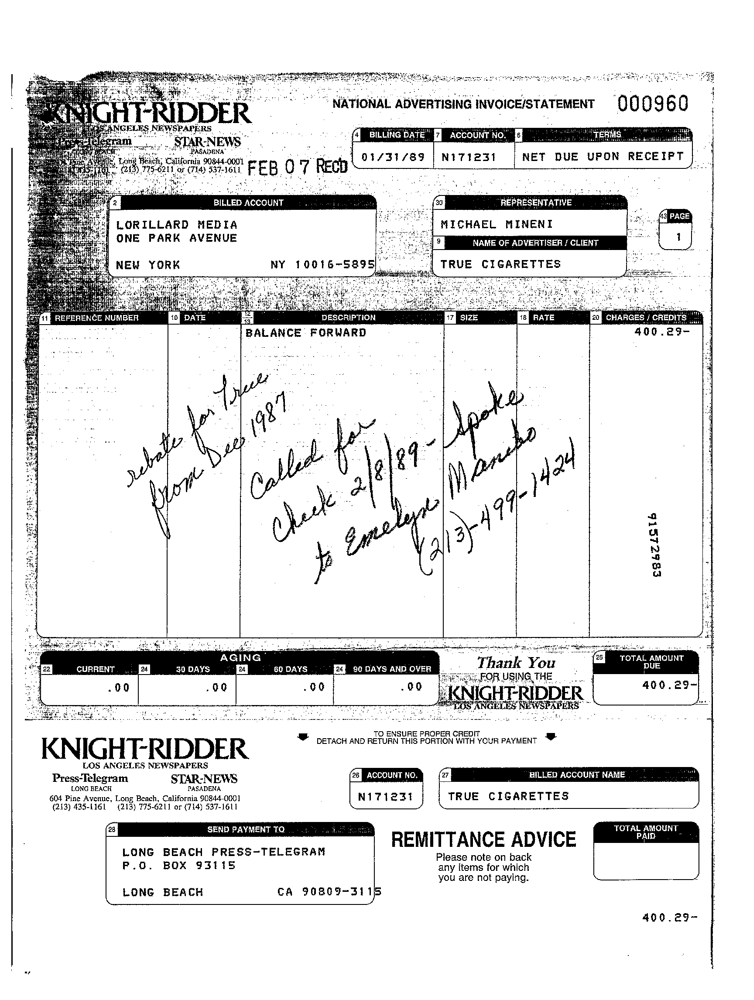


    Image #4:
    Origin: dbfs:/mnt/s3_dev/ocr/datasets/RVL-CDIP/test/invoice/2028697397.tif
    Resolution: 72 dpi
    Width: 777 px
    Height: 1000 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


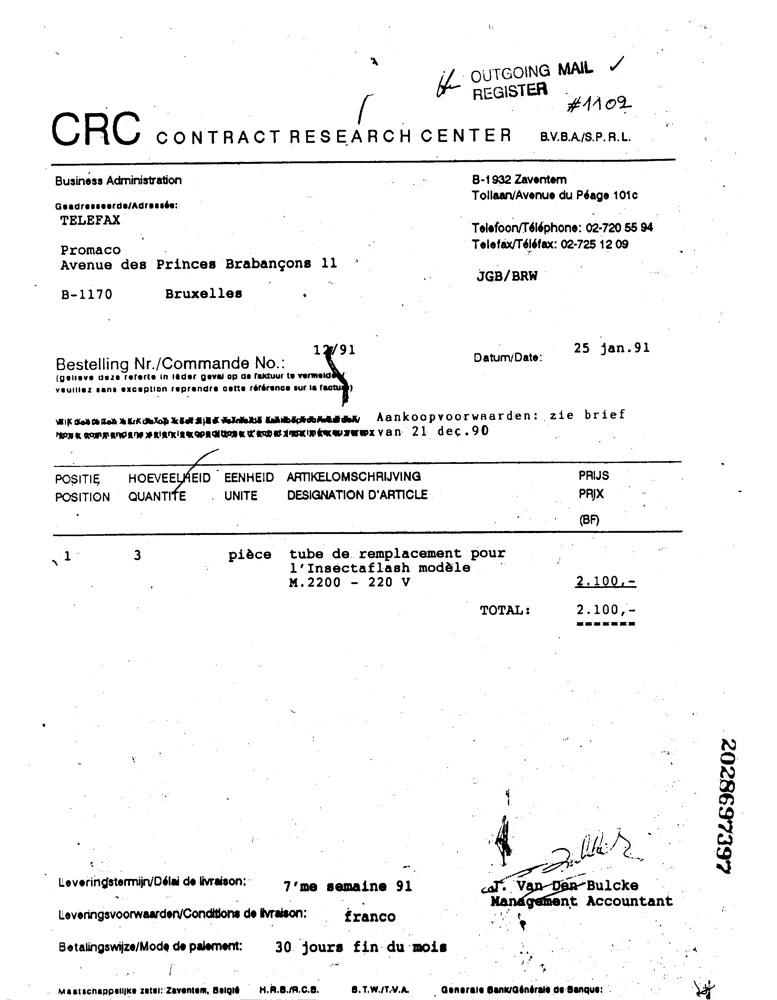

In [0]:
from pyspark.sql.functions import rand
from sparkocr.utils import display_images

selected = invoices.orderBy(rand()).limit(5).cache()
display_images(selected)

### Let's ask some questions!

In [0]:
questions = ['What is the total amount invoiced in the document?', 'What is the amount billed in the document?', 'What is the dollar amount mentioned in the document?']

In [0]:
visual_question_answering = VisualQuestionAnswering()\
    .pretrained("docvqa_donut_base", "en", "clinical/ocr")\
    .setQuestions(questions)\
    .setInputCol(['image']) \
    .setOutputCol("answers")


In [0]:
totals = visual_question_answering.transform(selected.repartition(5))
totals.select('answers', 'path').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------+
|answers                                                                                                                                                                                                  |path                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------+
|[ What is the total amount invoiced in the document? ->  $100.00,  What is the amount billed in the document? ->  $100.00,  What is the dollar amount mentioned in the document? 